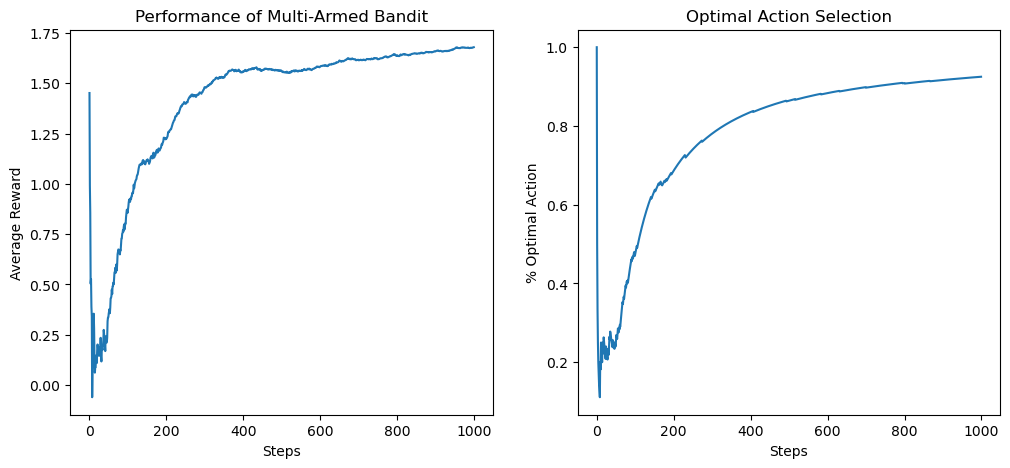

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class MultiArmedBandit:
    def __init__(self, k=10, epsilon=0.1, alpha=None, nonstationary=False, optimistic_init=0, UCB_c=2, gradient=False, baseline=True):
        self.k = k  # Number of arms
        self.epsilon = epsilon  # Exploration rate
        self.alpha = alpha  # Step-size parameter
        self.nonstationary = nonstationary  # Whether rewards change over time
        self.optimistic_init = optimistic_init  # Initial Q-values
        self.UCB_c = UCB_c  # UCB exploration factor
        self.gradient = gradient  # Whether to use gradient bandit algorithm
        self.baseline = baseline  # Whether to use a baseline in gradient bandit
        self.reset()

    def reset(self):
        self.q_true = np.random.randn(self.k)  # True action values
        self.q_est = np.full(self.k, self.optimistic_init)  # Estimated action values
        self.action_count = np.zeros(self.k)  # Count of actions taken
        self.preferences = np.zeros(self.k)  # Preferences for gradient bandit
        self.average_reward = 0  # Baseline reward
        self.time_step = 0  # Time step counter

    def get_reward(self, action):
        reward = np.random.randn() + self.q_true[action]
        if self.nonstationary:
            self.q_true += np.random.randn(self.k) * 0.01  # Drift in true values
        return reward

    def select_action(self):
        self.time_step += 1
        if self.gradient:
            prob = np.exp(self.preferences) / np.sum(np.exp(self.preferences))
            return np.random.choice(self.k, p=prob)
        elif np.random.rand() < self.epsilon:
            return np.random.choice(self.k)  # Random action
        elif self.UCB_c > 0:
            ucb_values = self.q_est + self.UCB_c * np.sqrt(np.log(self.time_step + 1) / (self.action_count + 1e-5))
            return np.argmax(ucb_values)
        else:
            return np.argmax(self.q_est)

    def update_estimates(self, action, reward):
        self.action_count[action] += 1
        if self.gradient:
            if self.baseline:
                self.average_reward += (reward - self.average_reward) / self.time_step
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            self.preferences += self.alpha * (reward - self.average_reward) * (one_hot - np.exp(self.preferences) / np.sum(np.exp(self.preferences)))
        else:
            step_size = self.alpha if self.alpha else (1 / self.action_count[action])
            self.q_est[action] += step_size * (reward - self.q_est[action])

    def run(self, steps=1000):
        rewards = np.zeros(steps)
        optimal_action_count = np.zeros(steps)
        for step in range(steps):
            action = self.select_action()
            reward = self.get_reward(action)
            self.update_estimates(action, reward)
            rewards[step] = reward
            optimal_action_count[step] = (action == np.argmax(self.q_true))
        return rewards, optimal_action_count

# Experiment settings
bandit = MultiArmedBandit(k=10, epsilon=0.1, alpha=0.1, nonstationary=True, optimistic_init=5, UCB_c=2, gradient=True)
rewards, optimal_action_count = bandit.run(steps=1000)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(rewards) / np.arange(1, 1001))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Performance of Multi-Armed Bandit')

plt.subplot(1, 2, 2)
plt.plot(np.cumsum(optimal_action_count) / np.arange(1, 1001))
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.title('Optimal Action Selection')

plt.show()
